## Regression with Categorical Variables

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
from scipy import stats
import statsmodels.api as sm

os.chdir('/Users/chengchen/Desktop/Insight/19C/')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
data_dir = 'Challenge_Video Game Sales/vgsales.csv'
df = pd.read_csv(data_dir)

### 1. Add dummy variables for categorical variables to regression input

In [17]:
def get_dummy(df_old, col_name):
    """
    take categorical column df_old.col_name, 
    transfer it to dummy variables,
    include all but one of them to the dataframe and make it a new dataframe,
    return the new dataframe and a list of newly added column name of the dummy variables
    """
    dummy_df = pd.get_dummies(df[col_name],prefix=col_name)
    # drop one dummy category to prevent multicolinearity
    # there's no strict rule to choose which one to drop
    # I choose the category with the least frequency
    drop_dummy = dummy_df.sum().sort_values().index[0]
    df_new = pd.concat([df_old, dummy_df], axis = 1).drop(drop_dummy, axis = 1)
    dummy_list = dummy_df.columns.tolist()
    dummy_list.remove(drop_dummy)  
    return df_new, dummy_list

In [31]:
df_expand, dummy_genre = get_dummy(df, 'Genre')
df_expand, dummy_platform = get_dummy(df_expand, 'Platform')
df_expand, dummy_publisher = get_dummy(df_expand, 'Publisher')
df_expand, dummy_year = get_dummy(df_expand, 'Year')
df_expand['ones']=1

In [32]:
df_expand.shape

(16598, 668)

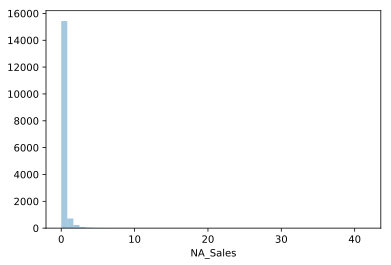

In [28]:
sns.distplot(df.NA_Sales, kde = False)

In [23]:
# log-transform the y's because their distrubitions are too skewed
y_JP = np.log(df_expand[['JP_Sales']]+1)
y_NA = np.log(df_expand[['NA_Sales']]+1)
y_EU = np.log(df_expand[['EU_Sales']]+1)

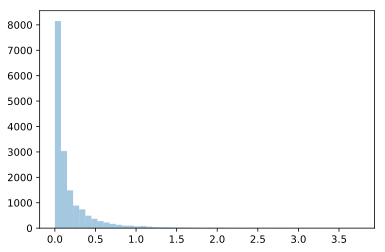

In [27]:
sns.distplot(y_NA, kde = False) 

In [33]:
X_var_list = ['ones']+ dummy_genre + dummy_year + dummy_platform + dummy_publisher
X_all = df_expand[X_var_list]
# X_all contains all possible independent variables (on the RHS of the regression)

### 2. Forward Selection for Features
Include the dummies from genre, year, platform, publisher sequentially into the linear regression model, use AIC/BIC as a criteria for model selection. (AIC/BIC awards higher prediction precision but puts punishment on using more number of features.)

In [90]:
def forward_feature_selection(X, y, print_log = 0):
    selected_col = ['ones'] # a list to store selected features
    all_col = X.columns.tolist() # a list contains all the features
    unselected_col = [x for x in all_col if x not in set(selected_col)] # a list to store unused features
    X_sub = X[selected_col] # a subsample of X that contains only selected columns
    est = sm.OLS(y, X_sub)
    results = est.fit()
    aic_0 = results.aic # Initial AIC with only intercept in the model
    for i in range(1, len(X.columns)):
        next_feature, aic_score = select_next_feature(X, selected_col, unselected_col, y)
        if aic_score < aic_0:
            aic_0 = aic_score
            selected_col.append(next_feature)
            unselected_col = [x for x in all_col if x not in set(selected_col)] # update list of selected & unselected columns
            if print_log:
                print('# features selected', len(selected_col))
                print('current AIC:', aic_0)
        else: return selected_col, aic_0
    return selected_col, aic_0

In [91]:
def select_next_feature(X, selected_X, unselected_X, y):
    aic_list = []
    for x in unselected_X:
        new_X = selected_X + [x]
        X_sub = X[new_X]
        est = sm.OLS(y, X_sub)
        results = est.fit()
        aic = results.aic
        aic_list.append(aic)
    index_min_aic = np.argmin(aic_list)
    return unselected_X[index_min_aic], aic_list[index_min_aic]       

In [94]:
X_selected, model_AIC = forward_feature_selection(X_all, y_JP, print_log = 1) 

# features selected 2
current AIC: -17153.742440004833
# features selected 3
current AIC: -18012.599886208664
# features selected 4
current AIC: -18788.61711385604
# features selected 5
current AIC: -19413.503725503928
# features selected 6
current AIC: -19796.30266115891
# features selected 7
current AIC: -20063.549133890025
# features selected 8
current AIC: -20288.51877789337
# features selected 9
current AIC: -20497.29404554652
# features selected 10
current AIC: -20658.90869397349
# features selected 11
current AIC: -20818.17761712512
# features selected 12
current AIC: -20961.206119522256
# features selected 13
current AIC: -21100.423216997828
# features selected 14
current AIC: -21245.694507011292
# features selected 15
current AIC: -21349.533851851585
# features selected 16
current AIC: -21454.255948425365
# features selected 17
current AIC: -21535.42464335924
# features selected 18
current AIC: -21590.14434133922
# features selected 19
current AIC: -21644.653073873815
# featur

(['ones',
  'Publisher_Nintendo',
  'Platform_NES',
  'Platform_SNES',
  'Genre_Role-Playing',
  'Platform_GB',
  'Publisher_SquareSoft',
  'Publisher_Enix Corporation',
  'Publisher_Namco Bandai Games',
  'Platform_SAT',
  'Platform_PS',
  'Publisher_Square Enix',
  'Publisher_Konami Digital Entertainment',
  'Publisher_Capcom',
  'Publisher_Sony Computer Entertainment',
  'Publisher_Level 5',
  'Publisher_Sega',
  'Publisher_Banpresto',
  'Publisher_Tecmo Koei',
  'Publisher_ASCII Entertainment',
  'Publisher_Hudson Soft',
  'Platform_3DS',
  'Platform_PS2',
  'Platform_PS3',
  'Platform_DC',
  'Year_1991.0',
  'Year_1992.0',
  'Platform_PSP',
  'Platform_DS',
  'Genre_Fighting',
  'Publisher_mixi, Inc',
  'Year_1989.0',
  'Publisher_HAL Laboratory',
  'Year_1986.0',
  'Publisher_Sony Computer Entertainment Europe',
  'Genre_Simulation',
  'Publisher_Ubisoft Annecy',
  'Publisher_Aruze Corp',
  'Publisher_Compile',
  'Publisher_Virgin Interactive',
  'Publisher_Square',
  'Platform_P

The forward-selection function took 2 hours to run... <br>
The regression result table is shown below. All variables that are statistically significant should be considered useful predictors of video game sales. 110 variables (including intercept) are selected.

In [155]:
X_sub = X_all[X_selected]
est = sm.OLS(y_JP, X_sub)
results = est.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               JP_Sales   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     105.9
Date:                Tue, 29 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:37:04   Log-Likelihood:                 11265.
No. Observations:               16598   AIC:                        -2.231e+04
Df Residuals:                   16488   BIC:                        -2.146e+04
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [159]:
df_results = pd.DataFrame(data = results.pvalues, columns = ['pvalue'])
df_results = df_results.join(pd.DataFrame(data = results.params, columns = ['params']))
df_results.head()

,pvalue,params
ones,3.181289e-15,-0.020844
Publisher_Nintendo,0.000000e+00,0.315431
Platform_NES,2.768473e-18,0.211032
Platform_SNES,3.568127e-31,0.151842
Genre_Role-Playing,1.609676e-61,0.059395


### 3. Alternative: Use Lasso Regression to Conduct Feature Selection

In [100]:
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=5, random_state=0, fit_intercept=False).fit(X_all, y_JP)

/Users/chengchen/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [133]:
X_lasso_sub = X_all[X_all.columns[(reg.coef_!=0).nonzero()]]

In [134]:
est = sm.OLS(y_JP, X_lasso_sub)
results = est.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               JP_Sales   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     110.1
Date:                Tue, 29 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:28:22   Log-Likelihood:                 11170.
No. Observations:               16598   AIC:                        -2.213e+04
Df Residuals:                   16495   BIC:                        -2.134e+04
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [172]:
X_lasso_selected_feature = X_lasso_sub.columns.tolist()

In [174]:
duplicate_features = len(set(X_lasso_selected_feature) & set(X_selected))

In [175]:
print('number of features selected from forward selection:', len(X_selected))
print('number of features selected from Lasso regression:', len(X_lasso_selected_feature))
print('number of common features selected by both methods:', duplicate_features)

number of features selected from forward selection: 110
number of features selected from Lasso regression: 103
number of common features selected by both methods: 72
